In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize

In [2]:
def cvt_local2global(local_point, sc_point):
    x, y, a = local_point.T
    X, Y, A = sc_point.T
    x1 = x * np.cos(A) - y * np.sin(A) + X
    y1 = x * np.sin(A) + y * np.cos(A) + Y
    a1 = (a + A) % (2 * np.pi)
    return np.array([x1, y1, a1]).T


def cvt_global2local(global_point, sc_point):
    x, y, a = global_point.T
    X, Y, A = sc_point.T
    x1 = x * np.cos(A) + y * np.sin(A) - X * np.cos(A) - Y * np.sin(A)
    y1 = -x * np.sin(A) + y * np.cos(A) + X * np.sin(A) - Y * np.cos(A)
    a1 = (a - A) % (2 * np.pi)
    return np.array([x1, y1, a1]).T

In [413]:
# Dimensions of the playing field
WORLD_X = 3000
WORLD_Y = 2000
WORLD_BORDER = 22
BEAC_R = 96.0 / 2
BEAC_L = 100.0
BEAC_BORDER = 22.0

ORANGE_BEACONS = np.array([[WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., WORLD_Y / 2.],
                           [-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), WORLD_Y - BEAC_L / 2.],
                           [-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), BEAC_L / 2.]])

GREEN_BEACONS = np.array([[-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), WORLD_Y / 2.],
                          [WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., WORLD_Y - BEAC_L / 2.],
                          [WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., BEAC_L / 2.]])

# parameters of lidar
BEAC_DIST_THRES = 300
LIDAR_DELTA_ANGLE = (np.pi / 180) / 4
LIDAR_START_ANGLE = -(np.pi / 2 + np.pi / 4)


class ParticleFilter:
    def __init__(self, particles_num=500, sense_noise=50, distance_noise=5, angle_noise=0.02, start_x=293, start_y=425,
                 start_angle=3 * np.pi / 2, color='orange', max_itens=3500.0, max_dist=3700.0,
                 back_side_cost=10):

        self.start_coords = np.array([start_x, start_y, start_angle])
        self.color = color
        if color == 'orange':
            self.beacons = ORANGE_BEACONS
        else:
            self.beacons = GREEN_BEACONS

        self.particles_num = particles_num
        self.sense_noise = sense_noise
        self.distance_noise = distance_noise
        self.angle_noise = angle_noise
        self.max_itens = max_itens
        self.max_dist = max_dist
        self.last = (start_x, start_y, start_angle)
        self.back_side_cost = back_side_cost

        # Create Particles
        x = np.random.normal(start_x, distance_noise, particles_num)
        y = np.random.normal(start_y, distance_noise, particles_num)
        angle = np.random.normal(start_angle, angle_noise, particles_num) % (2 * np.pi)
        self.particles = np.array([x, y, angle]).T
        self.landmarks = [[], []]
        
        self.min_cost_function = 0

    @staticmethod
    def gaus(x, mu=0, sigma=1):
        """calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma"""
        return np.exp(- ((x - mu) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * np.pi * (sigma ** 2))

    @staticmethod
    def p_trans(a, d):
        x_beac = d * np.cos(a)
        y_beac = d * np.sin(a)
        return x_beac, y_beac
    
    def localisation(self, delta_coords, lidar_data):
        self.move_particles([delta_coords[0], delta_coords[1], delta_coords[2]])
        self.particles = self.particle_sense(lidar_data, self.particles)
        main_robot = self.calculate_main()
        return main_robot

    def particle_sense(self, scan, particles):
        angle, distance = self.get_landmarks(scan)
        x_coords, y_coords = self.p_trans(angle, distance)
        self.landmarks = np.array([x_coords, y_coords])
        weights = self.weights(x_coords, y_coords, particles)
        inds = self.resample(weights)
        self.min_cost_function = np.mean(self.cost_function)
        particles = particles[inds, :]
        return particles
    
    def move_particles(self, delta):  # delta = [dx,dy,d_rot]
        x_noise = np.random.normal(0, self.distance_noise, self.particles_num)
        y_noise = np.random.normal(0, self.distance_noise, self.particles_num)
        angle_noise = np.random.normal(0, self.angle_noise, self.particles_num)
        noise = np.array([x_noise, y_noise, angle_noise]).T
        move_point = delta + noise
        self.particles = cvt_local2global(move_point, self.particles)

    def resample(self, weights):
        """ according to weights """
        n = self.particles_num
        weigths = np.array(weights)
        indices = []
        C = np.append([0.], np.cumsum(weigths))
        j = 0
        u0 = (np.random.rand() + np.arange(n)) / n
        for u in u0:
            while j < len(C) and u > C[j]:
                j += 1
            indices += [j - 1]
        return indices

    def calculate_main(self):
        x = np.mean(self.particles[:, 0])
        y = np.mean(self.particles[:, 1])
        zero_elem = self.particles[0, 2]
        # this helps if particles angles are close to 0 or 2*pi
        temporary = ((self.particles[:, 2] - zero_elem + np.pi) % (2.0 * np.pi)) + zero_elem - np.pi
        angle = np.mean(temporary)
        return np.array((x, y, angle))

    def weights(self, x_beac, y_beac, particles):
        """Calculate particle weights based on their pose and landmards"""
        # BEACONS: from global BEACONS to particles local: (X, Y) - Nx3x2 matrices, N - number of particles
        # determines 3 beacon positions (x,y) for every particle in it's local coords
        res = self.beacons[np.newaxis, :, :] - particles[:, np.newaxis, :2]
        X = (res[:, :, 0] * np.cos(particles[:, 2])[:, np.newaxis]
             + res[:, :, 1] * np.sin(particles[:, 2])[:, np.newaxis])
        Y = (-res[:, :, 0] * np.sin(particles[:, 2])[:, np.newaxis]
             + res[:, :, 1] * np.cos(particles[:, 2])[:, np.newaxis])
        beacon = np.concatenate((X[:, :, np.newaxis], Y[:, :, np.newaxis]), axis=2)

        # beacon = beacons are in local coordinates of particles. 
        # distance from theoretical beacons to detected landmarks from scan (x_beac, y_beac)
        # ln1, ln2, ln3: NxM (M - number of detected landmarks from scan)
        ln1 = (np.sqrt((beacon[:, np.newaxis, 0, 0] - x_beac[np.newaxis, :]) ** 2
                             + (beacon[:, np.newaxis, 0, 1] - y_beac[np.newaxis, :]) ** 2) - BEAC_R) ** 2
        ln2 = (np.sqrt((beacon[:, np.newaxis, 1, 0] - x_beac[np.newaxis, :]) ** 2
                             + (beacon[:, np.newaxis, 1, 1] - y_beac[np.newaxis, :]) ** 2) - BEAC_R) ** 2
        ln3 = (np.sqrt((beacon[:, np.newaxis, 2, 0] - x_beac[np.newaxis, :]) ** 2
                             + (beacon[:, np.newaxis, 2, 1] - y_beac[np.newaxis, :]) ** 2) - BEAC_R) ** 2

        # lns are differences in theoretical and detected beacon data from lidar
        # ln1,ln2,ln3 are correct computed OK)

        # get minimal distance for each particle, its detected beacons to theoretical beacons
        errors = np.minimum(ln1, np.minimum(ln2, ln3))
        if self.color == "orange":
            conds = (x_beac < self.beacons[0, 0]) * (x_beac > self.beacons[1, 0]) *\
                    (x_beac > self.beacons[2, 0]) * (y_beac < self.beacons[1, 1]) *\
                    (y_beac > self.beacons[2, 1])
        else:
            conds = (x_beac > self.beacons[0, 0]) * (x_beac < self.beacons[1, 0]) *\
                    (x_beac < self.beacons[2, 0]) * (y_beac < self.beacons[1, 1]) *\
                    (y_beac > self.beacons[2, 1])
        conds1 = errors < BEAC_DIST_THRES ** 2
        errors = conds * errors + self.back_side_cost ** 2 * (~ conds) * errors
        # too far real beacons go away: non valid
        num_errors = np.sum(conds1, axis=1)
        errors = errors * conds1
        sum_errors = np.sum(errors, axis=1)
#        print(num_errors[0], errors.shape[1])
#         print(errors)
#         print(errors < BEAC_DIST_THRES)
        self.cost_function = np.sqrt(np.where(sum_errors, sum_errors, 1000000)) /\
            np.where(num_errors, num_errors, 1)
    #-\
     #       2 * np.where(num_errors, num_errors, 1) 
        weights = self.gaus(self.cost_function, mu=0, sigma=self.sense_noise)
        if np.sum(weights) > 0:
            weights /= np.sum(weights)
        else:
            weights = np.ones(particles.shape[0], dtype=np.float) / particles.shape[0]
        return weights
    
    def get_landmarks(self, scan):
        """Returns filtrated lidar data"""
        ind = np.where(np.logical_and(scan[:, 1] > self.max_itens, scan[:, 0] < self.max_dist))[0]
        angles = (LIDAR_DELTA_ANGLE * ind + LIDAR_START_ANGLE) % (2 * np.pi)
        distances = scan[ind, 0]
        return angles, distances

In [339]:
start_point = np.array([735, 1080, 1.57])
lidar_point = np.array([0, 60, 1.57])
start_lidar_point = cvt_local2global(lidar_point, start_point)

In [340]:
pf = ParticleFilter(start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], max_itens=2000)

# Read data

In [217]:
scans = np.load("laser_scans1.npy")
N = scans.shape[0]

(-200, 2200)

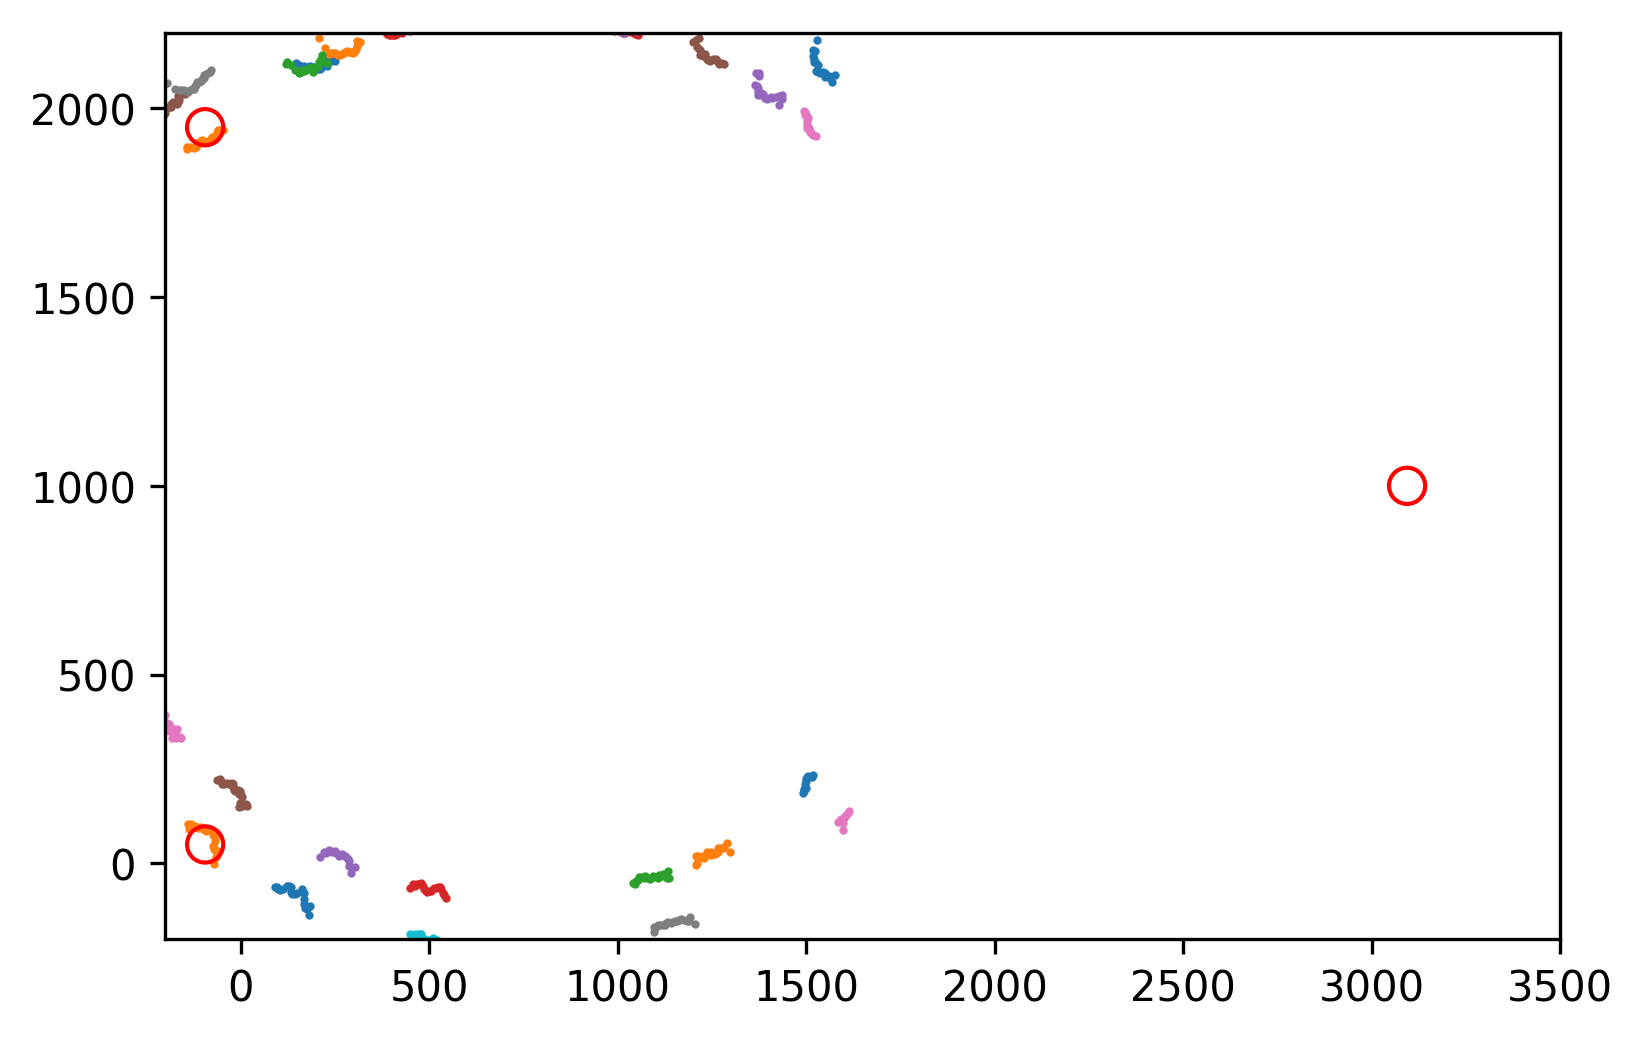

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(70, 100):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i]))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, start_lidar_point)[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
plt.xlim(-200, 3500)
plt.ylim(-200, 2200)

# Get odometry movement

In [219]:
raw_odom_coords = np.load("odom_coords1.npy")

In [220]:
odom_diff = cvt_global2local(raw_odom_coords, raw_odom_coords[0])
odom_robot_points = cvt_local2global(odom_diff, start_point)
odom_lidar_points = cvt_local2global(lidar_point, odom_robot_points)

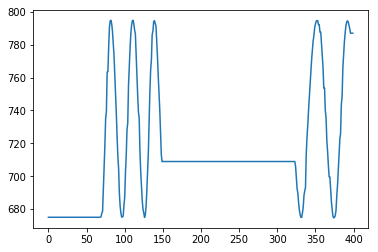

In [221]:
plt.plot(odom_lidar_points[:, 0])

## Laser scans in odom frames

(-200, 2200)

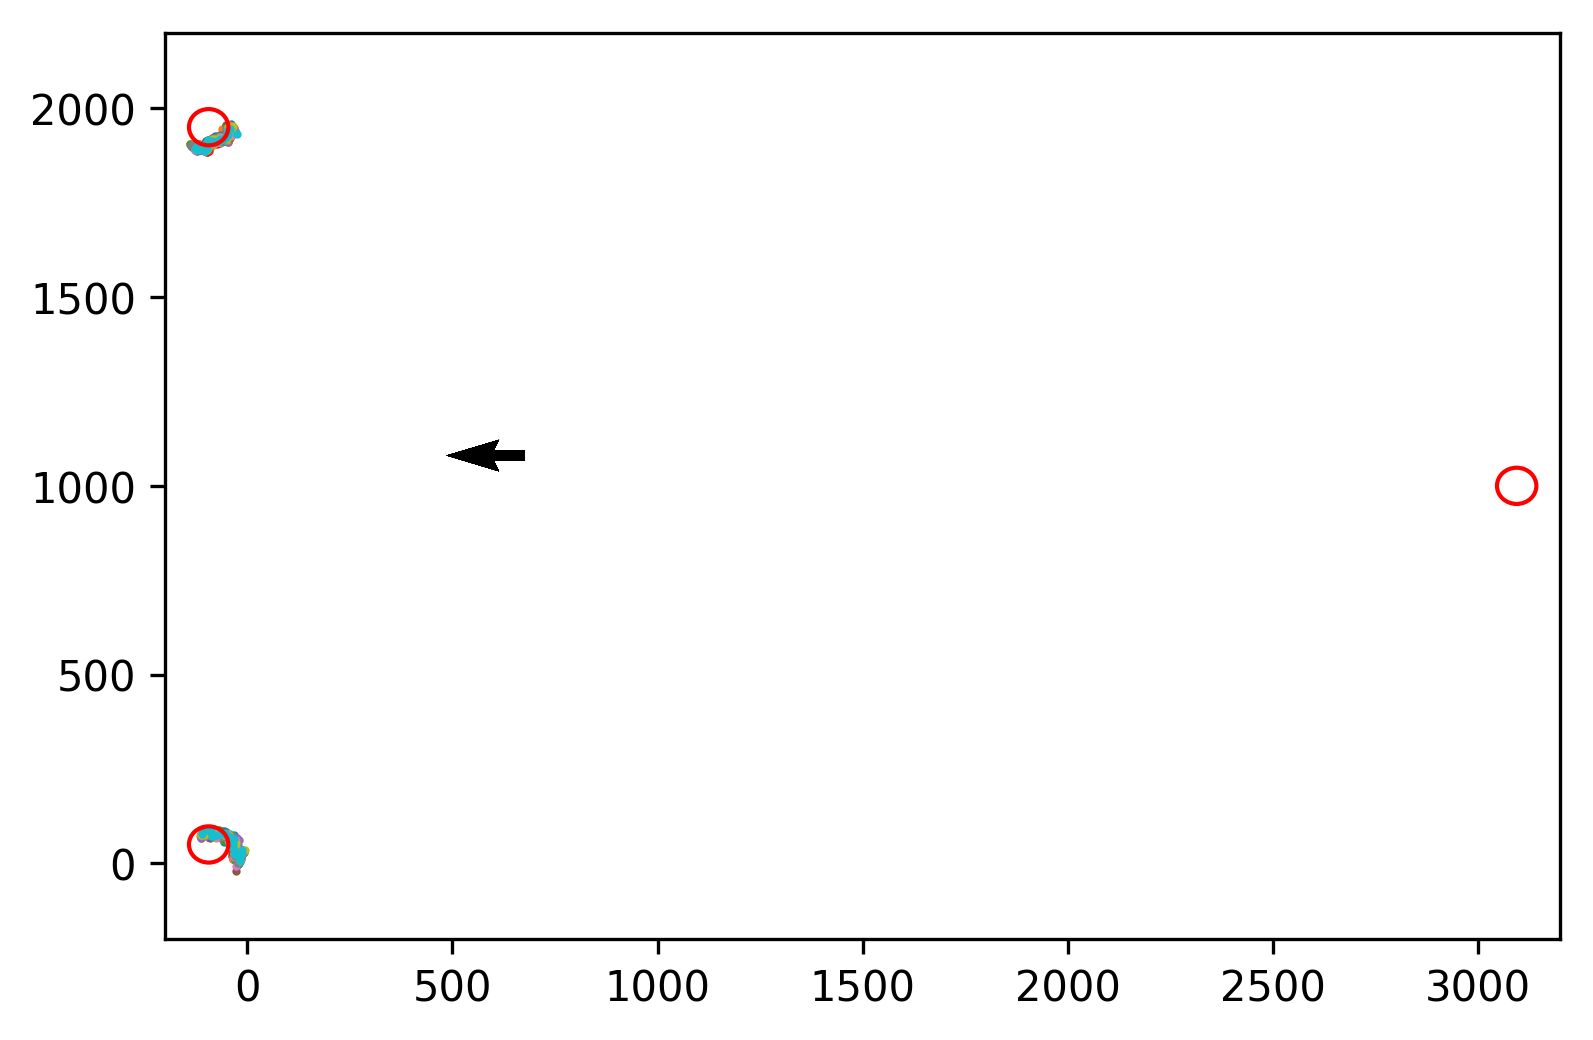

In [222]:
ind_start, ind_end = 0, 40
ps = odom_lidar_points[ind_start:ind_end]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(ind_start, ind_end):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i]))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, odom_lidar_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]))
plt.xlim(-200, 3200)
plt.ylim(-200, 2200)

## Delta coords

In [414]:
delta_coords = cvt_global2local(odom_lidar_points, np.roll(odom_lidar_points, 1, axis=0))
delta_coords[0] = np.array([0, 0, 0])
delta_coords[-1] = np.array([0, 0, 0])

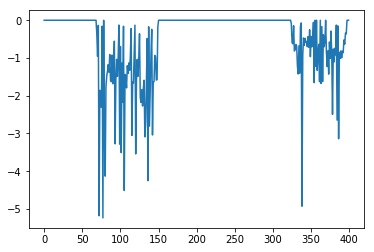

In [415]:
plt.plot(delta_coords[:, 0])

# Try PF

### angle_noise

In [575]:
angle_noises = np.linspace(0.04, 0.2, 10)
costs = []
for angle_noise in angle_noises:
    pf = ParticleFilter(start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], max_itens=2000, sense_noise=sense_noise, 
                    distance_noise=distance_noise, angle_noise=angle_noise, back_side_cost=back_side_cost)
    pf_points = []
    cost_functions = []
    for i in range(N):
        pf_points.append(pf.localisation(delta_coords[i], scans[i]))
        cost_functions.append(pf.min_cost_function)
    costs.append(np.sum(cost_functions[60:150]))

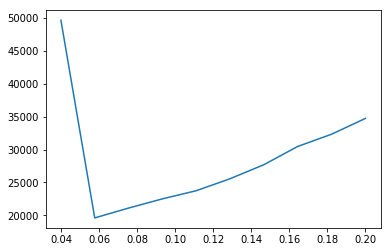

In [576]:
plt.plot(angle_noises, costs)

### sense_noise

In [556]:
sense_noises = np.linspace(1, 20, 10)
costs = []
for sense_noise in sense_noises:
    pf = ParticleFilter(start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], max_itens=2000, sense_noise=sense_noise, 
                    distance_noise=distance_noise, angle_noise=angle_noise, back_side_cost=back_side_cost)
    pf_points = []
    cost_functions = []
    for i in range(N):
        pf_points.append(pf.localisation(delta_coords[i], scans[i]))
        cost_functions.append(pf.min_cost_function)
    costs.append(np.sum(cost_functions[60:150]))

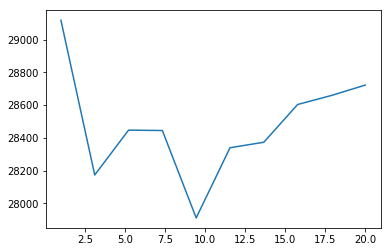

In [557]:
plt.plot(sense_noises, costs)

### distance_noise

In [500]:
distance_noises = np.linspace(2, 10, 10)
costs = []
for distance_noise in distance_noises:
    pf = ParticleFilter(start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], max_itens=2000, sense_noise=sense_noise, 
                    distance_noise=distance_noise, angle_noise=angle_noise, back_side_cost=back_side_cost)
    pf_points = []
    cost_functions = []
    for i in range(N):
        pf_points.append(pf.localisation(delta_coords[i], scans[i]))
        cost_functions.append(pf.min_cost_function)
    costs.append(np.sum(cost_functions))

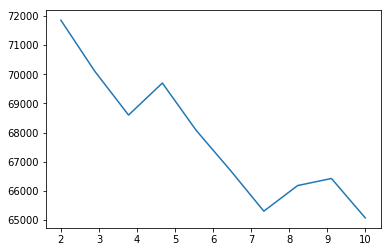

In [501]:
plt.plot(distance_noises, costs)

## Optimal params

In [514]:
# sense_noise = 10
# distance_noise = 1
# angle_noise = 0.2
# max_itens=3000
# back_side_cost=10

In [634]:
sense_noise = 10
distance_noise = 1
angle_noise = 0.15
max_itens=3000
back_side_cost=10

In [635]:
pf = ParticleFilter(start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], max_itens=2000, sense_noise=sense_noise, 
                    distance_noise=distance_noise, angle_noise=angle_noise, back_side_cost=back_side_cost)
pf_points = []
cost_functions = []
all_particles = []
for i in range(N):
    pf_points.append(pf.localisation(delta_coords[i], scans[i]))
    cost_functions.append(pf.min_cost_function)
    all_particles.append(pf.particles.copy())
pf_points = np.array(pf_points)
all_particles = np.array(all_particles)

28312.608642027855


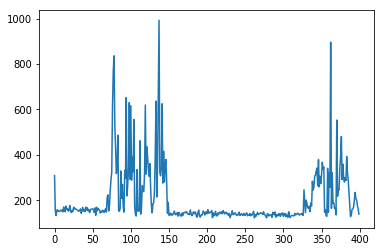

In [636]:
plt.plot(cost_functions)
print(np.sum(cost_functions[60:150]))

(-200, 2200)

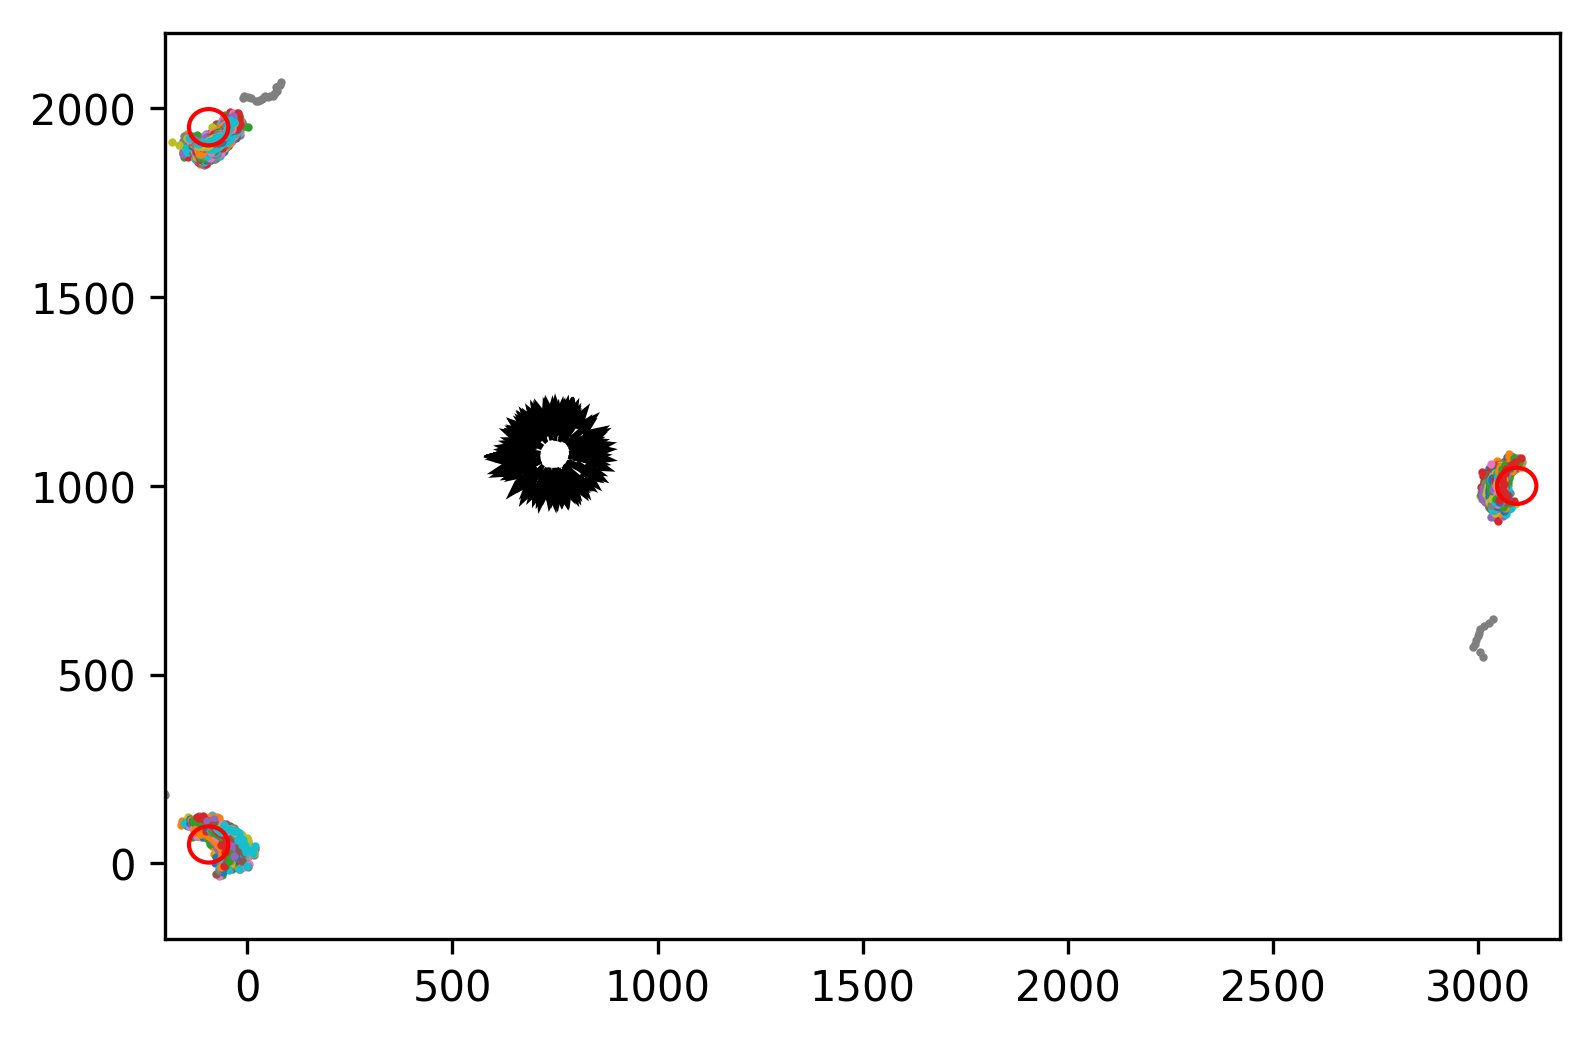

In [637]:
ind_start, ind_end = 0, 400
ps = pf_points[ind_start:ind_end]
ps1 = odom_lidar_points[ind_start:ind_end]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
  
for i in range(ind_start, ind_end):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i]))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, pf_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]), width=0.003)
plt.xlim(-200, 3200)
plt.ylim(-200, 2200)

In [629]:
pf.beacons

array([[3094., 1000.],
       [ -94., 1950.],
       [ -94.,   50.]])

## Particles

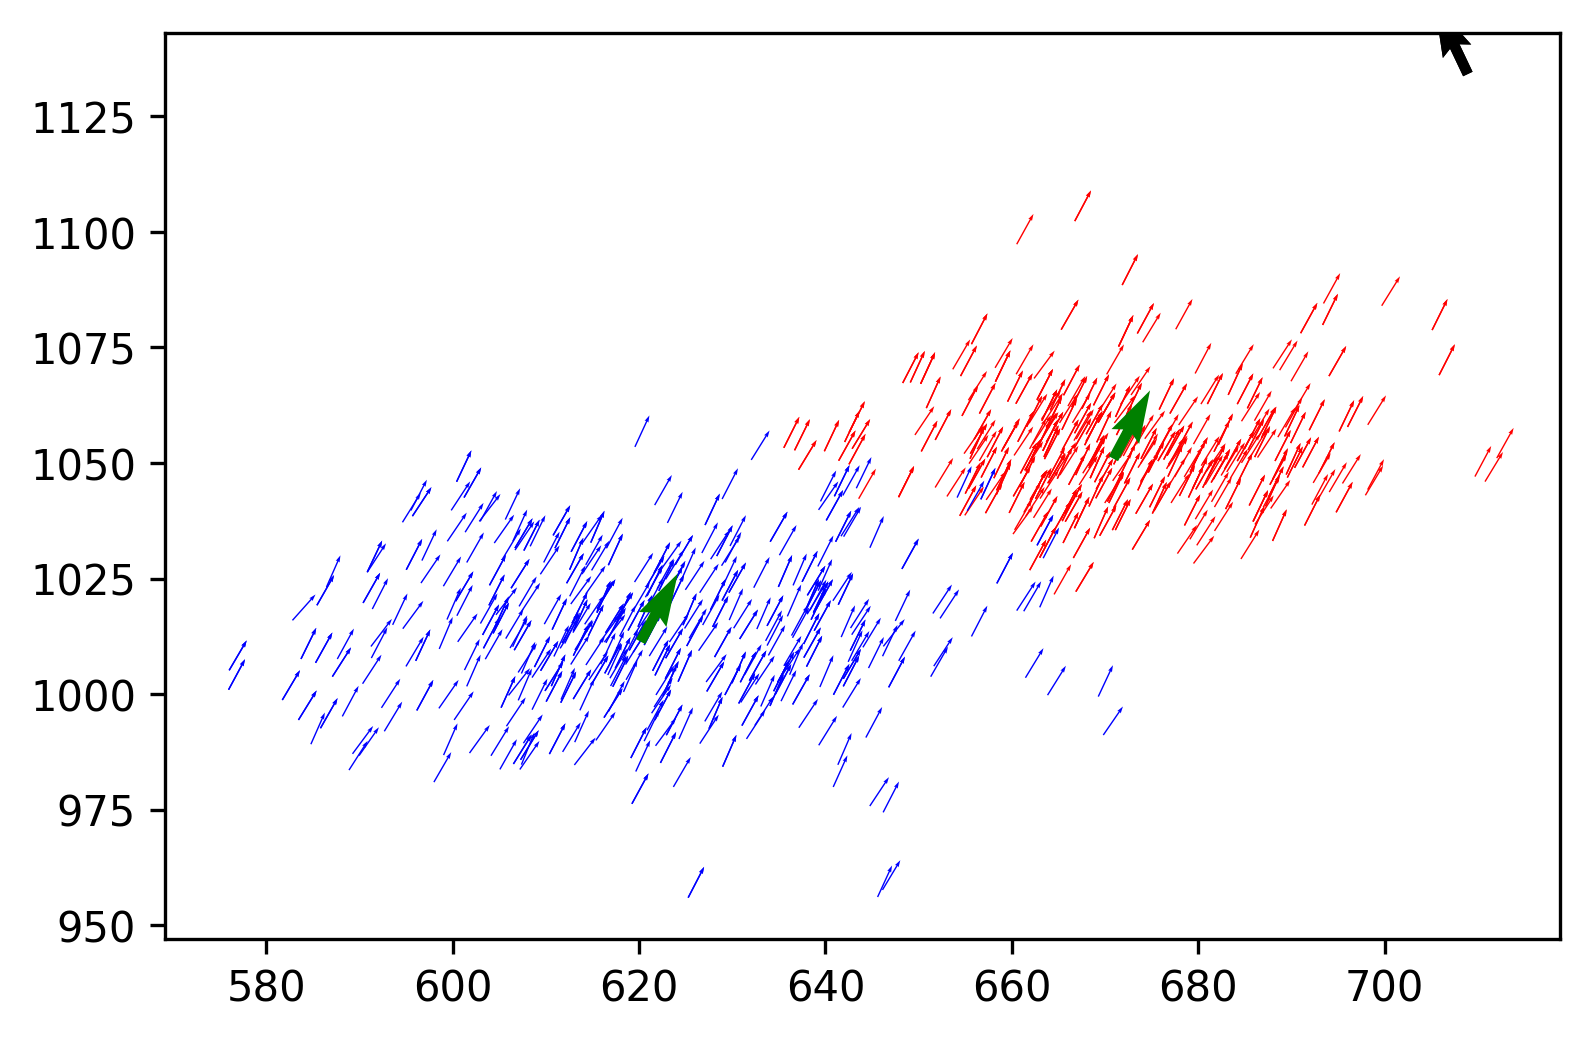

In [535]:
ind1 = 240
ind2 = 300
op1 = odom_lidar_points[ind1]
op2 = odom_lidar_points[ind2]
pf1 = pf_points[ind1]
pf2 = pf_points[ind2]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ps = all_particles[ind1]
ps1 = all_particles[ind2]
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]), width=0.001, color="red")
ax.quiver(ps1[:, 0], ps1[:, 1], np.cos(ps1[:, 2]), np.sin(ps1[:, 2]), width=0.001, color="blue")
ax.quiver(op1[0], op1[1], np.cos(op1[2]), np.sin(op1[2]))
ax.quiver(op2[0], op2[1], np.cos(op2[2]), np.sin(op2[2]))
ax.quiver(pf1[0], pf1[1], np.cos(pf1[2]), np.sin(pf1[2]), color="green")
ax.quiver(pf2[0], pf2[1], np.cos(pf2[2]), np.sin(pf2[2]), color="green")
# plt.xlim(500, 1000)
# plt.ylim(500, 1500)

In [230]:
delta_coords[50]

array([9.99200722e-15, 0.00000000e+00, 0.00000000e+00])

4.602059738214757


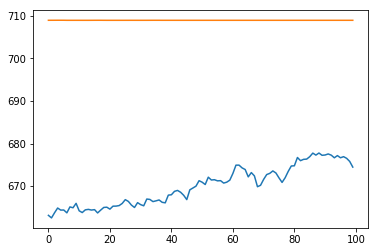

In [231]:
plt.plot(pf_points[200:300, 0])
plt.plot(odom_lidar_points[200:300, 0])
print(np.std(pf_points[200:300, 0]))

2.637515104778942


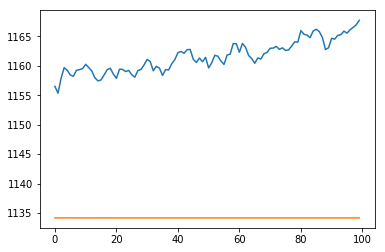

In [232]:
plt.plot(pf_points[200:300, 1])
plt.plot(odom_lidar_points[200:300, 1])
print(np.std(pf_points[200:300, 1]))

In [74]:
print(np.std(pf_points[:20, 0]))

0.1784258286071399


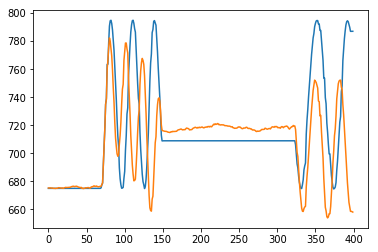

In [281]:
plt.plot(odom_lidar_points[:, 0])
plt.plot(pf_points[:, 0])

# Find beacons

In [395]:

def fun(beacon, points):
    return np.sqrt((beacon[0] - points[:, 0]) ** 2 + (beacon[1] - points[:, 1]) ** 2) - BEAC_R

def find_beacon(points, init_beacon):
    return scipy.optimize.least_squares(fun, init_beacon, args=(points,))

def get_xy_scan_points(scan, sc_point):
    x, y = pf.p_trans(*pf.get_landmarks(scan))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    points = cvt_local2global(points, sc_point)[:, 0:2]
    return points

def devide_points_beacons(points, beacons):
    beac_dist = np.sqrt((points[:, 0, np.newaxis] - beacons[np.newaxis, :, 0]) ** 2 +\
        (points[:, 1, np.newaxis] - beacons[np.newaxis, :, 1]) ** 2)
    points_ind = np.argmin(beac_dist, axis=1)
    min_beac_dist = np.min(beac_dist, axis=1)
    return points_ind, min_beac_dist

def get_new_beacons(old_beacons, points):
    beac_dist = np.sqrt((points[:, 0, np.newaxis] - old_beacons[np.newaxis, :, 0]) ** 2 +\
        (points[:, 1, np.newaxis] - old_beacons[np.newaxis, :, 1]) ** 2)
    points_ind = np.argmin(beac_dist, axis=1)
    min_beac_dist = np.min(beac_dist, axis=1)
    new_beacons = old_beacons.copy()
    for i in range(3):
        points_beac = points[(min_beac_dist < BEAC_DIST_THRES) * (points_ind == i)]
        if points_beac.shape[0] > 3:
            new_beacon = find_beacon(points_beac, pf.beacons[i].copy()).x
            new_beacons[i] = new_beacon
    return new_beacons

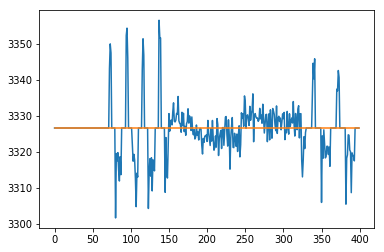

In [396]:
distances = []
old_distances = []
all_new_beacons = []
for i in range(400):
    points = get_xy_scan_points(scans[i], pf_points[i])
    new_beacons = get_new_beacons(pf.beacons, points)
    all_new_beacons.append(new_beacons)
    distances.append(np.linalg.norm(new_beacons[0] - new_beacons[1]))
    old_distances.append(np.linalg.norm(pf.beacons[0] - pf.beacons[1]))

all_new_beacons = np.array(all_new_beacons)
distances = np.array(distances)
inds = np.logical_or(np.all(all_new_beacons[:, 1] == pf.beacons[1], axis=1),
                     np.all(all_new_beacons[:, 0] == pf.beacons[0], axis=1))
distances[inds] = old_distances[0]
plt.plot(distances)
plt.plot(old_distances)

(-200, 2200)

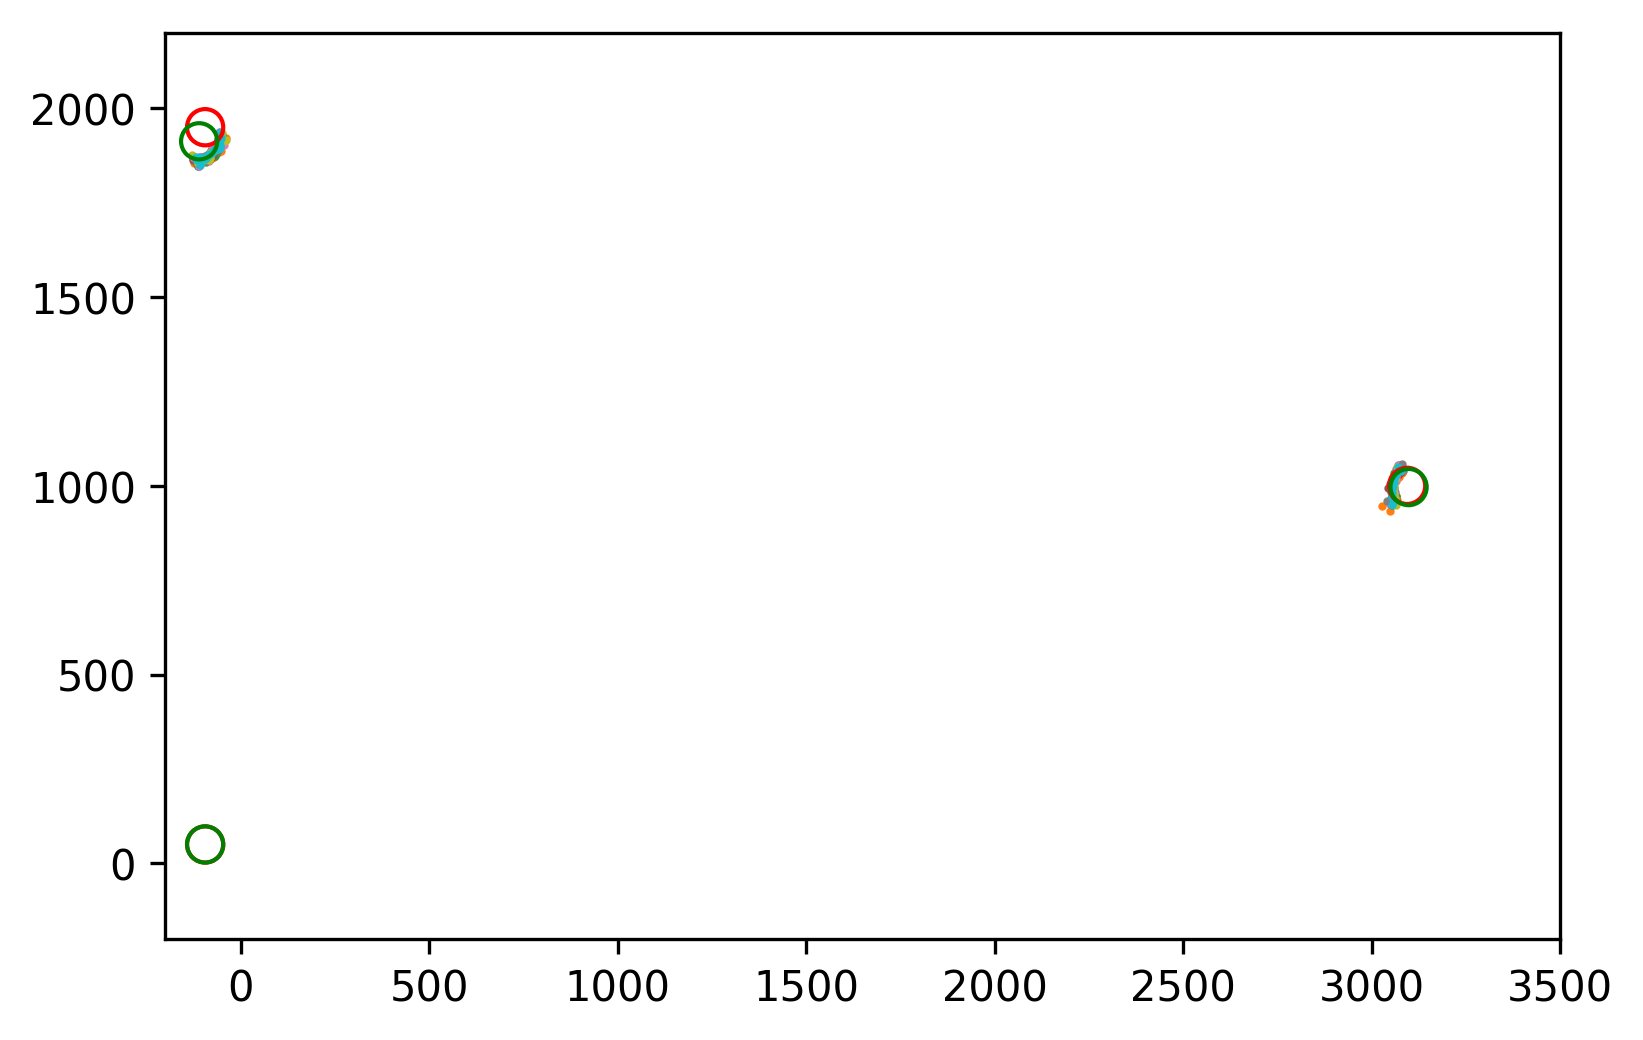

In [397]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(250, 260):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i]))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, pf_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
for b in all_new_beacons[260]:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="g"))
plt.xlim(-200, 3500)
plt.ylim(-200, 2200)

In [ ]:
distances[65]

In [ ]:
old_distances[65]

# Trianglulation

In [283]:
def fun_1(X, points, num_beacons):
    beacons = pf.beacons[num_beacons]
    points = cvt_local2global(points, X)[:, 0:2]
    r = np.sum((beacons - points) ** 2, axis=1) ** 0.5 - BEAC_R
    return r

In [320]:
ind = 201
x, y = pf.p_trans(*pf.get_landmarks(scans[ind]))
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y

init_X = np.array([770, 1150, 1.26])
apr_points = get_xy_scan_points(scans[ind], init_X)
beacons_len = np.sum((pf.beacons[np.newaxis, :, :] - apr_points[:, np.newaxis, :]
                     ) ** 2, axis=2) ** 0.5
points = points[np.min(beacons_len, axis=1) < BEAC_DIST_THRES]
num_beacons = np.argmin(beacons_len[np.min(beacons_len, axis=1) < BEAC_DIST_THRES], axis=1)

In [322]:
np.sqrt(np.sum(fun_1(init_X, points, num_beacons).round() ** 2))

65.53624951124378

In [323]:
np.sqrt(np.sum(fun_1(pf_points[ind], points, num_beacons).round() ** 2))

343.2040209554661

In [324]:
np.sqrt(np.sum(fun_1(tr_point, points, num_beacons).round() ** 2))

1216.372475847756

In [327]:
np.sqrt(np.sum(fun_1(tr_point, points, num_beacons).round() ** 2))

28.982753492378876

In [326]:
res = scipy.optimize.least_squares(fun_1, init_X,
                                   args=[points, num_beacons], ftol=1e-3)
tr_point = res.x

(-200, 2200)

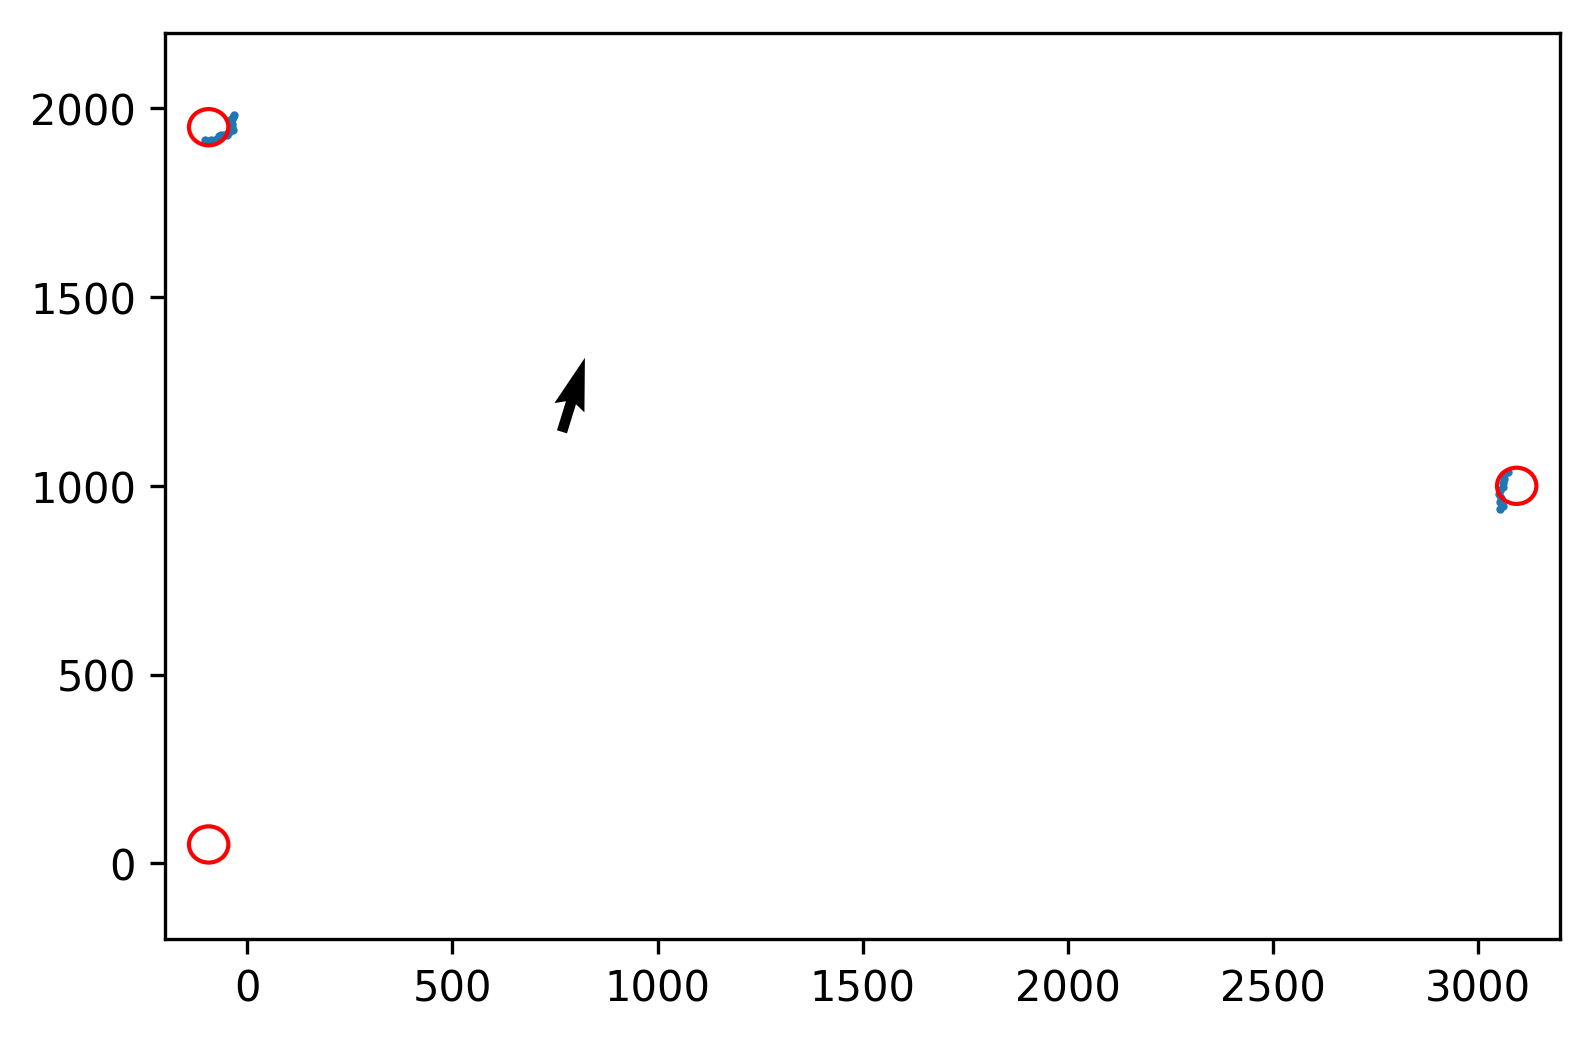

In [328]:
ind_start, ind_end = 201, 202
ps = np.array([tr_point])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
init_X = np.array([770, 1150, 1.26])
for i in range(ind_start, ind_end):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i]))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, init_X)[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]))
plt.xlim(-200, 3200)
plt.ylim(-200, 2200)